In [1]:
import os
import subprocess
from pathlib import Path

"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from src.choosingCountries.utils.beers_breweries import plot_beer_breweries_distribution
from src.choosingCountries.utils.users import plot_users
from src.choosingCountries.utils.reviews import plot_reviews
from scipy.stats import pearsonr



Exploring the data to see which locations give us the most data based on the number of reviews for beers of that country and number of reviews coming out of that country.

BeerAdvocate exploration

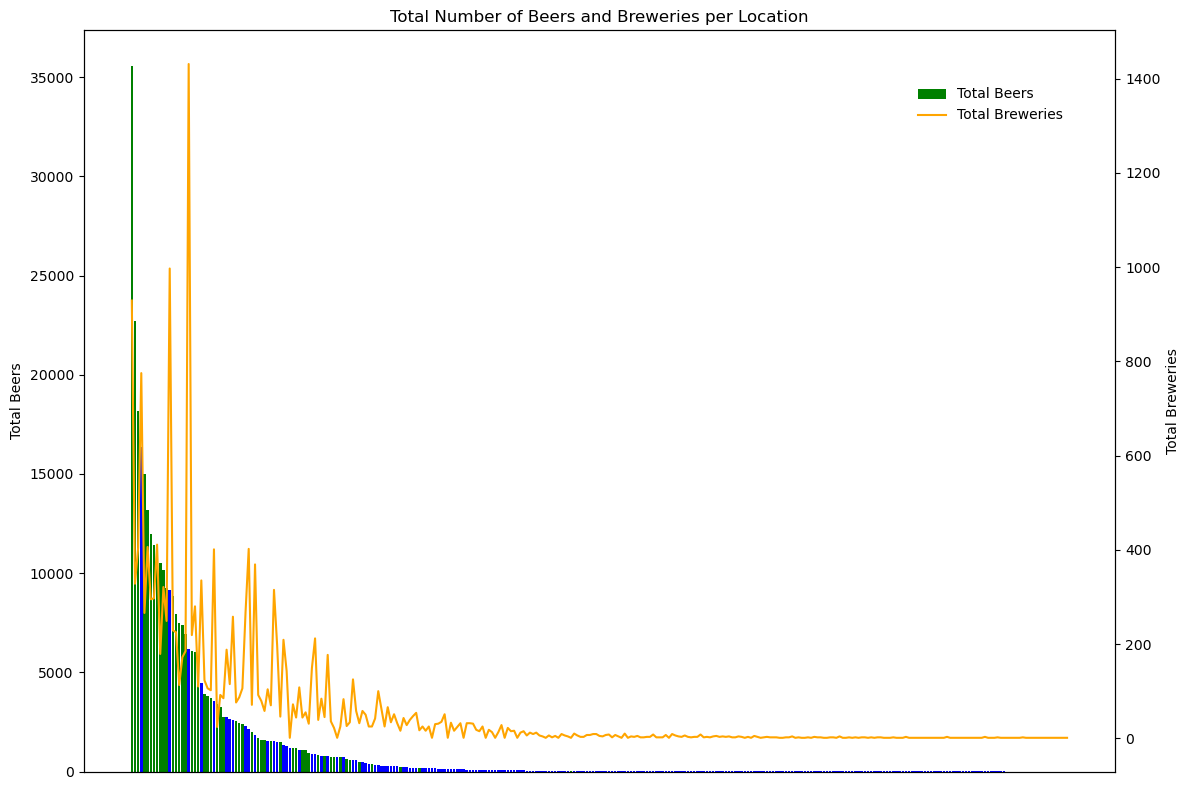

In [ ]:
breweries = pd.read_csv('data/minimizedData/BA_breweries_small.csv')
plot_beer_breweries_distribution(breweries)

Number of users with known locations: 122425


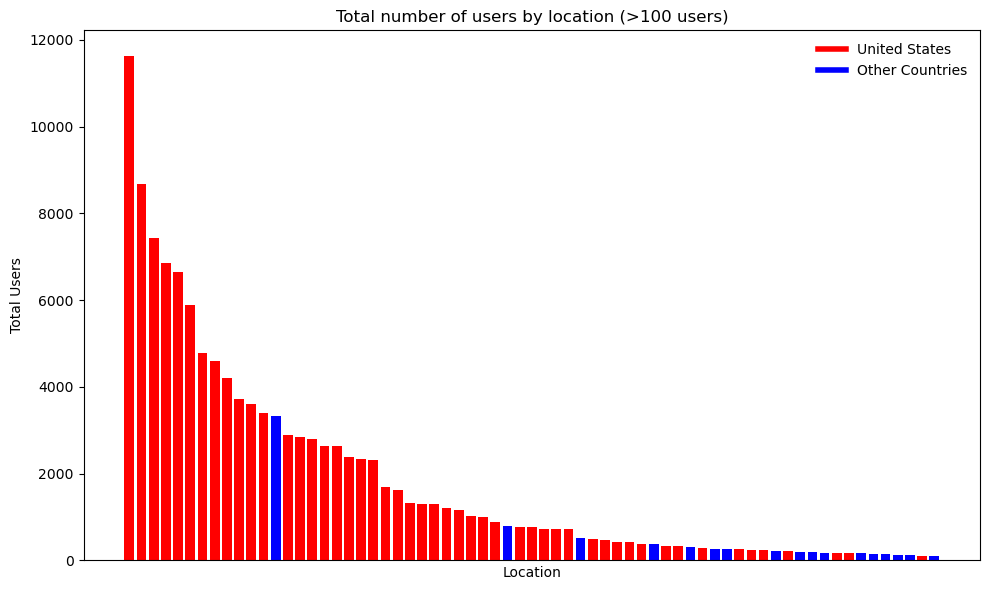

In [4]:
users = pd.read_csv('data/minimizedData/BA_users_small.csv')
plot_users(users)

In [ ]:
us_users = users[users['location'].fillna('').str.startswith('United States,')]

us_user_counts = us_users.groupby('location').size().reset_index(name='total_users')

us_user_counts = us_user_counts.sort_values(by='total_users', ascending=False)


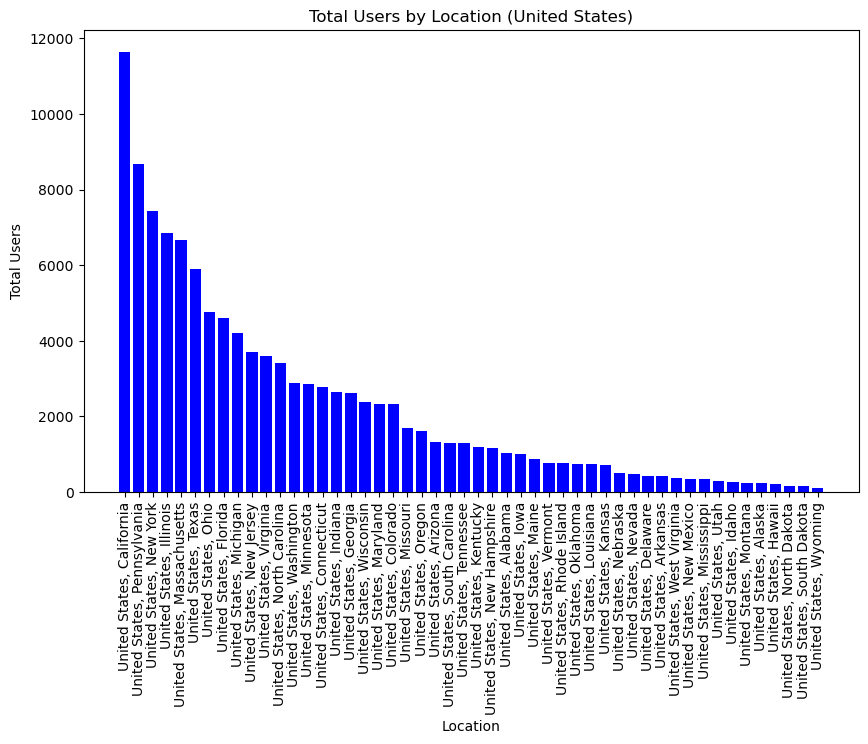

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(us_user_counts['location'], us_user_counts['total_users'], color='blue')
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users by Location (United States)')
plt.xticks(rotation=90)
plt.show()

In [ ]:
BA_merged = pd.read_csv('data/minimizedData/BA_ratings_small_plus.csv')
BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]
BA_merged_cleaned = BA_merged[BA_merged['beer_location'].notna()]

local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  
    total_beers=('nbr_beers', 'sum')  
).reset_index()

country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

country_data = country_data.sort_values(by='local_reviews', ascending=False)




LOCAL REVIEWS: number of reviews from a specific country for beers of the same country

NON LOCAL REVIEWS: number of reviews from a specific country given to beers from OTHER countries

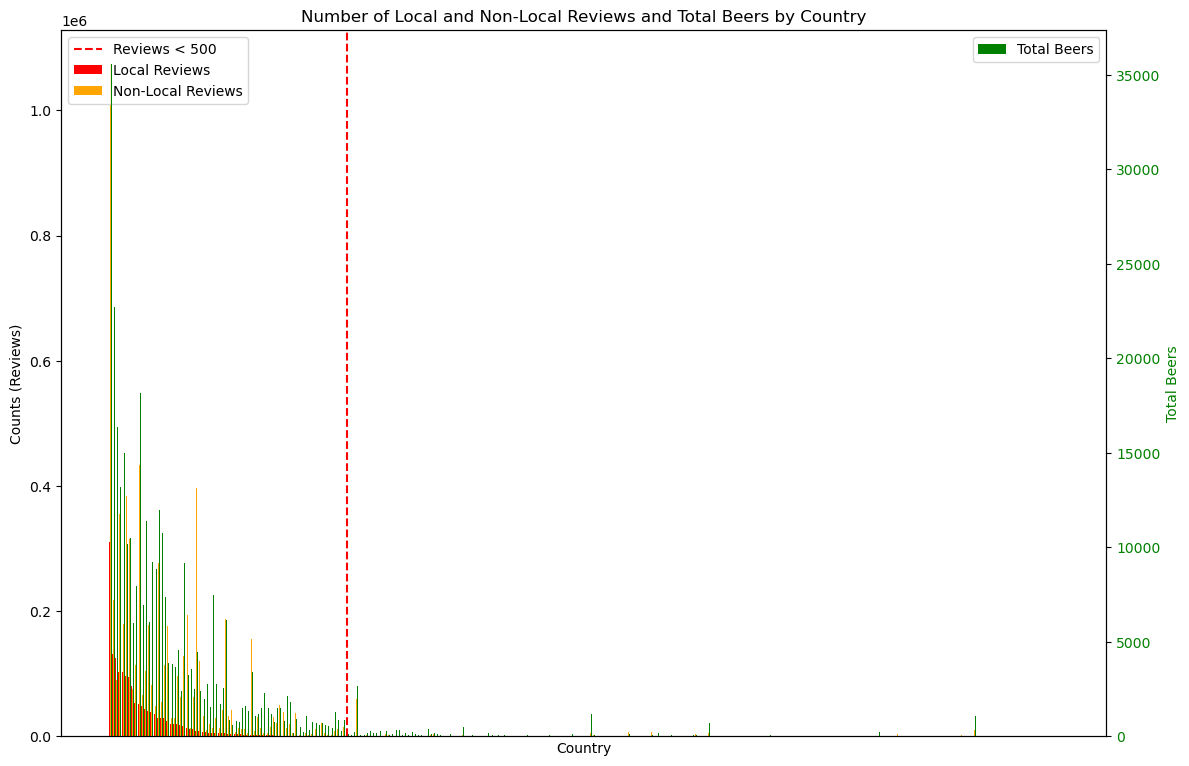

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.3
index = range(len(country_data))

bar1 = ax1.bar(index, country_data['local_reviews'], bar_width, label='Local Reviews', color='red')
bar2 = ax1.bar([i + bar_width for i in index], country_data['non_local_reviews'], bar_width, label='Non-Local Reviews', color='orange')


ax1.set_xlabel('Country')
ax1.set_ylabel('Counts (Reviews)', color='black')
ax1.set_title('Number of Local and Non-Local Reviews and Total Beers by Country')


ax2 = ax1.twinx()
bar3 = ax2.bar([i + 2 * bar_width for i in index], country_data['total_beers'], bar_width, label='Total Beers', color='green')

ax2.set_ylabel('Total Beers', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#where there are less than 500 non local and local reviews
for i in range(len(country_data)):  
    if country_data['local_reviews'].iloc[i] < 500 and country_data['non_local_reviews'].iloc[i] < 500:
        line_x = i + bar_width 
        break
if line_x is not None:
    ax1.axvline(x=line_x, color='red', linestyle='--', label='Reviews < 500')

ax1.legend(loc='upper left')
plt.tight_layout()
ax1.set_xticks([])
plt.show()


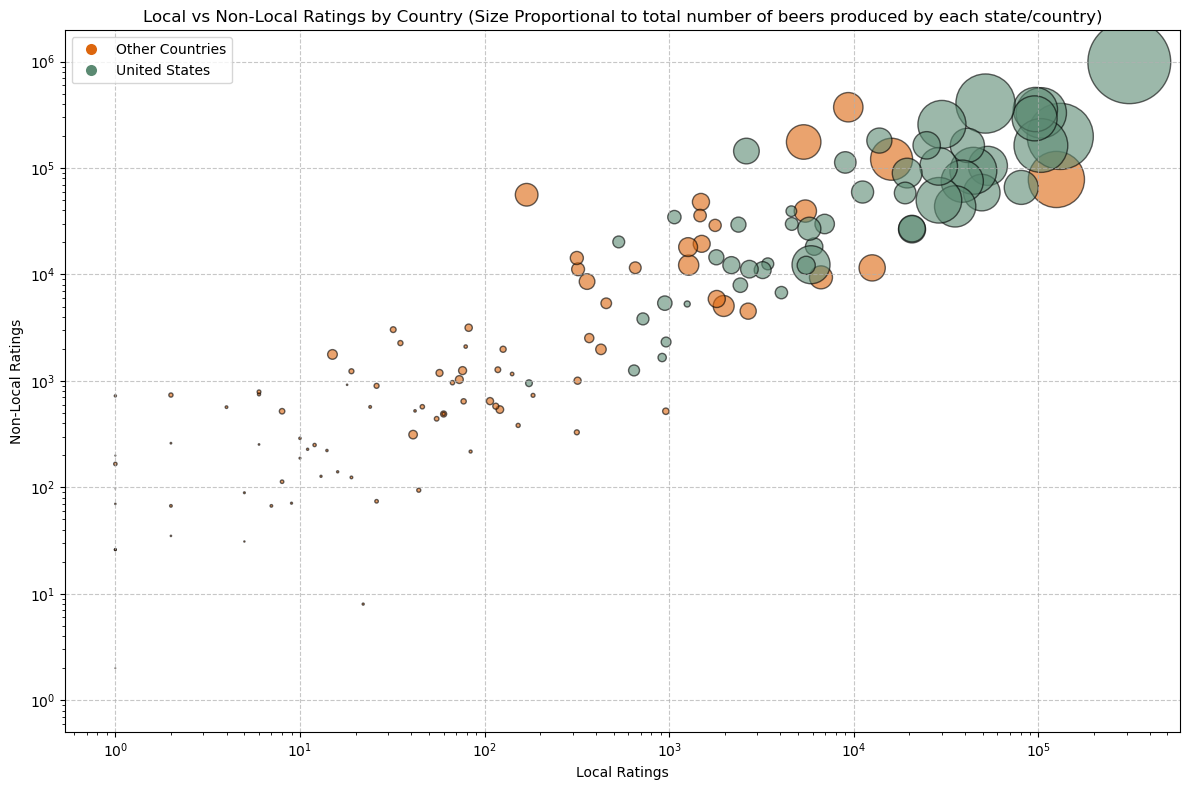

In [9]:
breweries = pd.read_csv('data/minimizedData/BA_breweries_small.csv')
BA_merged = pd.read_csv('data/minimizedData/BA_ratings_small_plus.csv')

plot_reviews(breweries, BA_merged)

The figure above illustrates the bar chart better. The size of the circles are proportinal to the total number of beers produced by the location concerned.

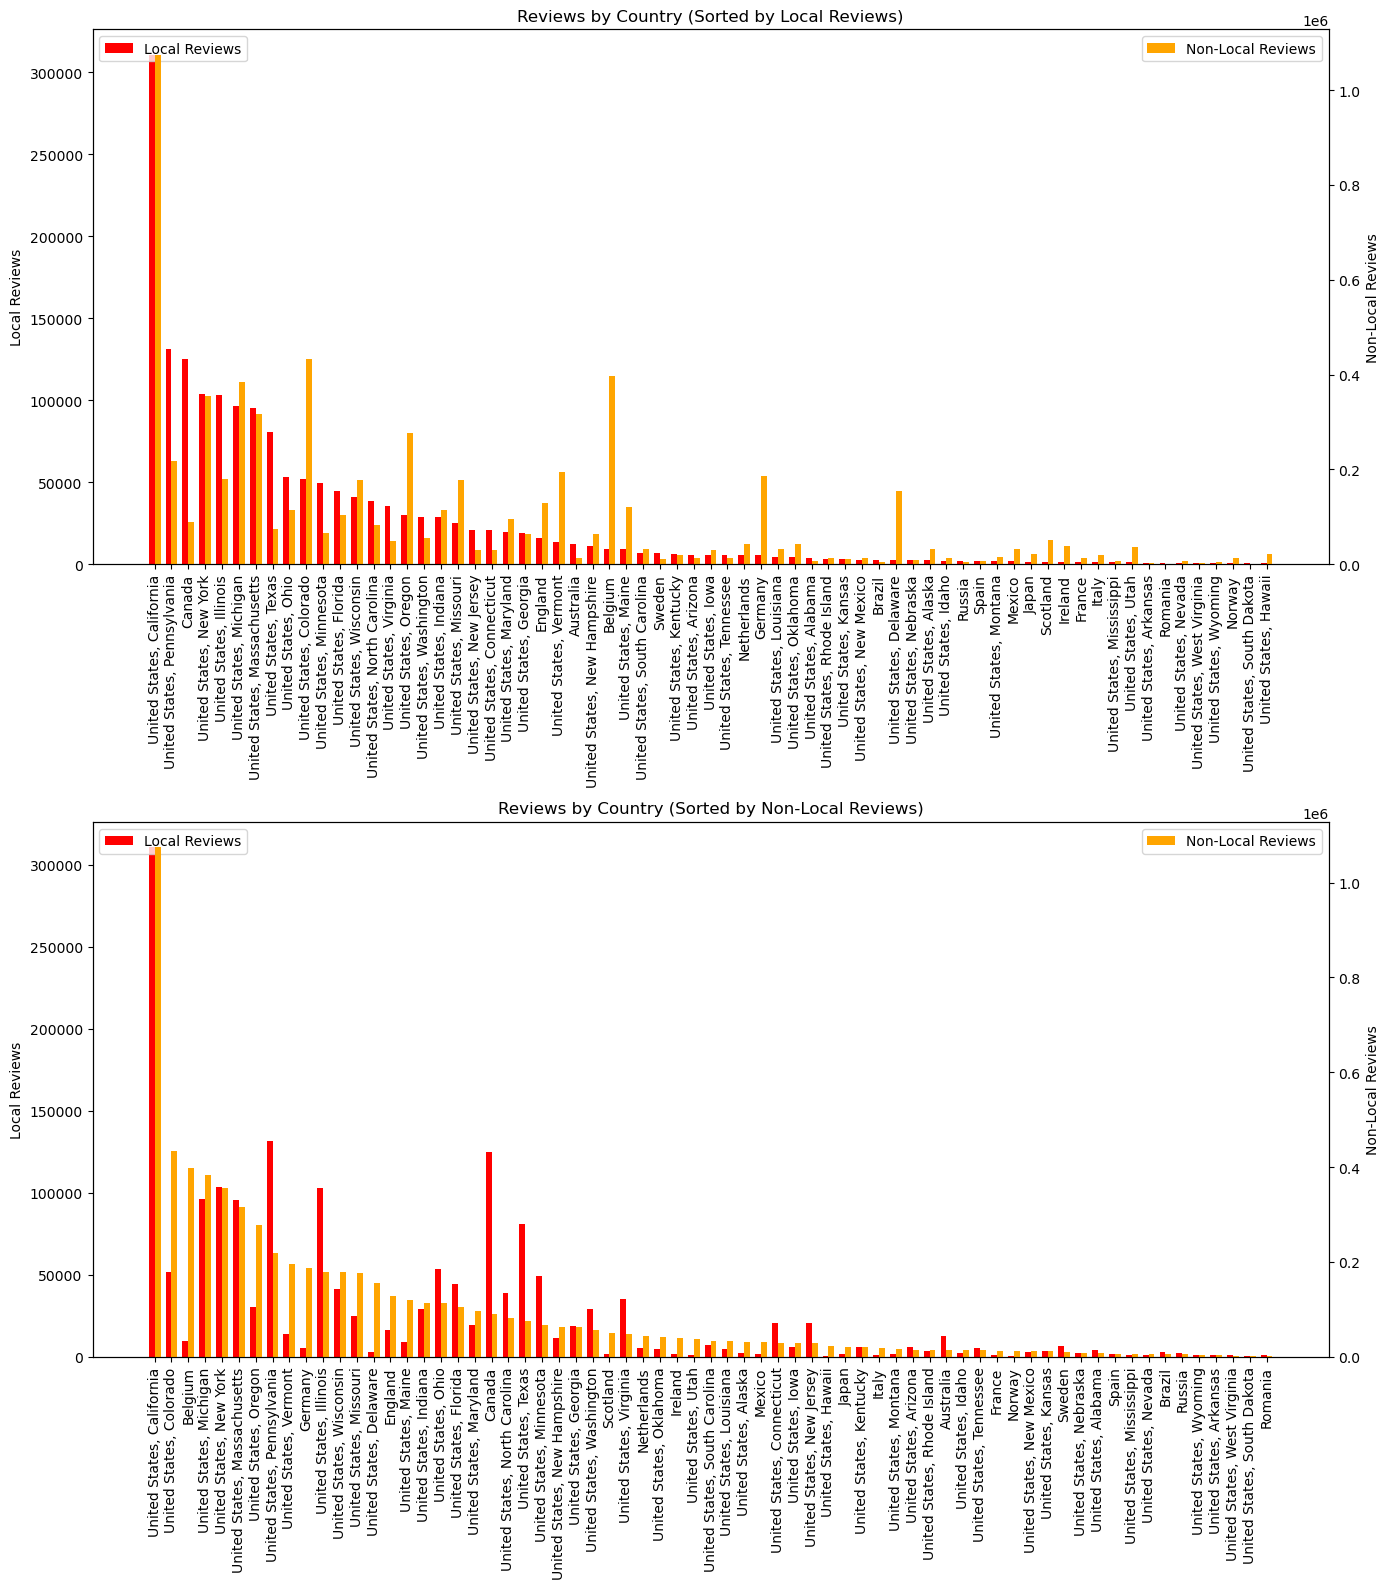

In [ ]:
filtered_country_data = country_data[(country_data['local_reviews'] >= 500) & (country_data['non_local_reviews'] >= 500)]

sorted_local = filtered_country_data.sort_values(by='local_reviews', ascending=False)
sorted_non_local = filtered_country_data.sort_values(by='non_local_reviews', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

bar_width = 0.35
index_local = range(len(sorted_local))
index_non_local = range(len(sorted_non_local))

ax1.bar(index_local, sorted_local['local_reviews'], bar_width, color='red', label='Local Reviews')
ax1.set_ylabel('Local Reviews')
ax1.set_title('Reviews by Country (Sorted by Local Reviews)')
ax1.set_xticks([i + bar_width / 2 for i in index_local])
ax1.set_xticklabels(sorted_local['location'], rotation=90)

ax1_right = ax1.twinx()
ax1_right.bar([i + bar_width for i in index_local], sorted_local['non_local_reviews'], bar_width, color='orange', label='Non-Local Reviews')
ax1_right.set_ylabel('Non-Local Reviews')

ax1.legend(loc='upper left')
ax1_right.legend(loc='upper right')

ax2.bar(index_non_local, sorted_non_local['local_reviews'], bar_width, color='red', label='Local Reviews')
ax2.set_ylabel('Local Reviews')
ax2.set_title('Reviews by Country (Sorted by Non-Local Reviews)')
ax2.set_xticks([i + bar_width / 2 for i in index_non_local])
ax2.set_xticklabels(sorted_non_local['location'], rotation=90)

ax2_right = ax2.twinx()
ax2_right.bar([i + bar_width for i in index_non_local], sorted_non_local['non_local_reviews'], bar_width, color='orange', label='Non-Local Reviews')
ax2_right.set_ylabel('Non-Local Reviews')

ax2.legend(loc='upper left')
ax2_right.legend(loc='upper right')
plt.tight_layout()
plt.show()


The figure above plots the number of local and non local reviews for each country based on ordering in descending order of either local and non local reviews. Visually we can see that there is a positive correlation between the 2. Therefore let us quantify this correlation.

Let's perform a Pearson test to verify and quantify this relationship. (A low p-value (e.g., < 0.05) would indicate that the correlation is statistically significant.)

In [ ]:

correlation = filtered_country_data[['local_reviews', 'non_local_reviews']].corr().iloc[0, 1]
print(f"Correlation between local and non-local reviews: {correlation}")
correlation, p_value = pearsonr(filtered_country_data['local_reviews'], filtered_country_data['non_local_reviews'])
print(f"Pearson correlation: {correlation}, p-value: {p_value}")
print("The low p value suggests that this correlation output is indded statistically significant")

Correlation between local and non-local reviews: 0.82628489507921
Pearson correlation: 0.8262848950792101, p-value: 7.40318671639054e-18
The low p value suggests that this correlation output is indded statistically significant


Therefore since the 2 are linearly correlated, we could simply take the top N countries directly from either the ordering of local or non local reviews. We could also standardise the number of local and non local reviews and select our top N countries in this way. Standardisation needs to be used in order to consider the fact that the order of size of local and non local reviews are not the same. (There are many more non local reviews than there are local ones)

Below we are standardising using the z score [maybe insert equation here] the number local and non local reviews to obtain the top N countries- here we are are not putting a weight on either local or non local reviews.

[Alternative reasoning] Based on the scatter plot above we can directly see that this dataset not only contains a high amount of US beers but also a large proportion of the data is also has both local and non-local US beers and therefore it makes sense for us to focus our analysis in this direction for the BeerAdvocate dataset.

In [ ]:
N = 50

local_mean = country_data['local_reviews'].mean()
local_std = country_data['local_reviews'].std()

non_local_mean = country_data['non_local_reviews'].mean()
non_local_std = country_data['non_local_reviews'].std()

country_data['local_reviews_scaled'] = (country_data['local_reviews'] - local_mean) / local_std
country_data['non_local_reviews_scaled'] = (country_data['non_local_reviews'] - non_local_mean) / non_local_std

country_data['combined_score'] = (country_data['local_reviews_scaled'] + country_data['non_local_reviews_scaled']) / 2

top_n_countries = country_data.sort_values(by='combined_score', ascending=False).head(N)  # Replace N with the desired number of top countries


print(top_n_countries[['location', 'local_reviews', 'non_local_reviews', 'combined_score']])


                          location  local_reviews  non_local_reviews  \
207      United States, California       310621.0          1074377.0   
224        United States, Michigan        96266.0           383282.0   
234        United States, New York       103588.0           355362.0   
240    United States, Pennsylvania       131261.0           218250.0   
223   United States, Massachusetts        95340.0           316008.0   
208        United States, Colorado        51676.0           433127.0   
215        United States, Illinois       103115.0           178791.0   
28                          Canada       125101.0            89427.0   
15                         Belgium         9335.0           397510.0   
239          United States, Oregon        30018.0           277623.0   
245           United States, Texas        80715.0            75057.0   
252       United States, Wisconsin        41216.0           177518.0   
237            United States, Ohio        53235.0           1134

Based on the z score we can see that many of the locations that have a lot of both local and non local reviews are the US states.